### Set your directories.

Edit ```basedir``` according to the location of folder containing this repo.



In [1]:
basedir = '/home/abhinavgupta0110/generalized_nCM'

import os

is_google_colab = False
is_use_GPU = False

Edit ```os.chdir(os.path.join(basedir, 'Poly_Collocation_Solver'))``` with the folder name containing this repo.

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

os.chdir(os.path.join(basedir, 'generalized_nCMs'))

%load_ext autoreload

### Load packages as per need.

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.kdv_burgers_eqn_case.kdv_burgers_eqn as burg
from src.kdv_burgers_eqn_case.kdv_burgers_eqn_helper_classes import * 

from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

from matplotlib.animation import FuncAnimation, PillowWriter
from numpy import random

### Define some useful classes

#### Initial conditions

#### Analytical solution

In [4]:
class ad_eqn_analy:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u = self.x / (t + 1.) / (1. + np.sqrt(np.divide(t + 1., self.app.t0), dtype = np.float64) * np.exp(self.app.Re * (self.x**2 / ((4. * t) + 4.)), dtype = np.float64))
        return tf.convert_to_tensor([u], dtype=tf.float32)

### Main part starts here

#### User-defined parameters and create objects

In [5]:
args = burg.kdv_burg_args(T = 2, nt = 200, x_left = -10, x_right = 10, Nx = 100, Re = 1000, dbc_l = 1, nbc_l = 0, dbc_r = 0, nbc_r = 1, max_deriv = 3, 
                          acc = 2, acc_advec = 4, eta_1 = 1.2, eta_2 = 0.8, x_1 = -6.0, x_2 = -2.0)
model_dir = 'burgers_fd/model_dir_case_test'
args_high = burg.kdv_burg_args(T = 2, nt = 200, x_left = -10, x_right = 10, Nx = 200, Re = 1000, dbc_l = 1, nbc_l = 0, dbc_r = 0, nbc_r = 1,  max_deriv = 3, 
                               acc = 2, acc_advec = 2, eta_1 = 1.2, eta_2 = 0.8, x_1 = -6.0, x_2 = -2.0)

In [6]:
os.chdir(basedir)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
os.chdir(model_dir)

In [7]:
t = tf.linspace(0., args.T, args.nt)

In [8]:
grid_obj = fdgen.grid(args)
u0 = initial_cond(grid_obj.x_grid_real, args)

deriv_obj = fdgen.deriv(args, grid_obj)

sol_obj = burg.burg_rhs(args, deriv_obj, grid_obj)

u = ddeinttf(sol_obj, u0, t, alg_name = 'vode', nsteps = 100)

/home/abhinavgupta0110/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1013: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


In [9]:
grid_obj_high = fdgen.grid(args_high)
u0 = initial_cond(grid_obj_high.x_grid_real, args_high)

deriv_obj_high = fdgen.deriv(args_high, grid_obj_high)

sol_obj = burg.burg_rhs(args_high, deriv_obj_high, grid_obj_high)

u_high = ddeinttf(sol_obj, u0, t, alg_name = 'vode', nsteps = 100)

#### Solve and plot

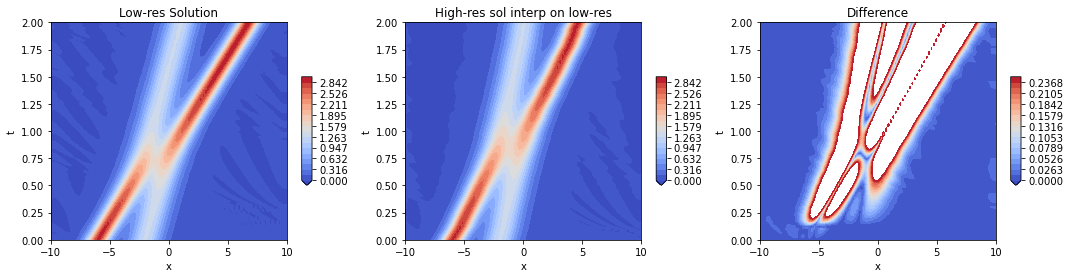

In [10]:
###########################################################
# First plot the solution on the original grid
###########################################################
fig = plt.figure(figsize=(18, 4), facecolor='white')
ax_u = fig.add_subplot(131)
ax_u_high = fig.add_subplot(132)
ax_u_analy = fig.add_subplot(133)

X, T = np.meshgrid(grid_obj.x_grid_real, t.numpy())

ax_u.cla()
ax_u.set_title('Low-res Solution')
ax_u.set_xlabel('x')
ax_u.set_ylabel('t')
plot = ax_u.contourf(X, T, tf.squeeze(u, axis=1).numpy(), cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 3.0, 20), extend='min')
ax_u.set_xlim(grid_obj.x_grid_real[0], grid_obj.x_grid_real[-1])
ax_u.set_ylim(t[0], t[-1])
plt.colorbar(plot, ax=ax_u, shrink=0.5, aspect=10)

###########################################################
# Sample the Chebyshev collocation solution on a high-res. grid
###########################################################

u_high_intp_low = interp_high_res_to_low_res(u_high, grid_obj_high.x_grid, grid_obj.x_grid, t)

ax_u_high.cla()
ax_u_high.set_title('High-res sol interp on low-res')
ax_u_high.set_xlabel('x')
ax_u_high.set_ylabel('t')
plot = ax_u_high.contourf(X, T, tf.squeeze(u_high_intp_low, axis=1).numpy(), cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 3.0, 20), extend='min')
ax_u_high.set_xlim(grid_obj.x_grid_real[0], grid_obj.x_grid_real[-1])
ax_u_high.set_ylim(t[0], t[-1])
plt.colorbar(plot, ax=ax_u_high, shrink=0.5, aspect=10)

###########################################################
# Plot difference w.r.t. analytical solution
###########################################################

ax_u_analy.cla()
ax_u_analy.set_title('Difference')
ax_u_analy.set_xlabel('x')
ax_u_analy.set_ylabel('t')
plot = ax_u_analy.contourf(X, T, np.abs(tf.squeeze(u_high_intp_low, axis=1).numpy() - tf.squeeze(u, axis=1).numpy()), cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 0.25, 20), extend='min')
ax_u_analy.set_xlim(grid_obj.x_grid_real[0], grid_obj.x_grid_real[-1])
ax_u_analy.set_ylim(t[0], t[-1])
plt.colorbar(plot, ax=ax_u_analy, shrink=0.5, aspect=10)

fig.show()

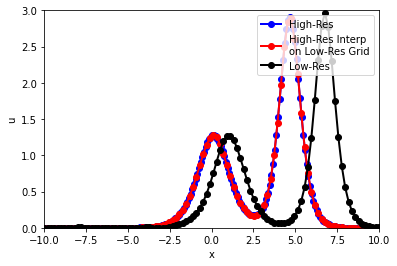

In [11]:
fig, ax = plt.subplots()
line, = plt.plot([], [], 'o-', lw=2)
labels = ['High-Res', 'High-Res Interp \non Low-Res Grid', 'Low-Res']

plotlays, plotcols = [3], ["blue","red", "black"]
lines = []
for index in range(3):
    lobj = ax.plot([],[], 'o-', lw=2,color=plotcols[index])[0]
    lines.append(lobj)

def init():
    ax.set_xlim(-10, 10.)
    ax.set_ylim(0, 3.0)
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    
    for line in lines:
        line.set_data([],[])
    return lines

def update(frame):
    xdata = [grid_obj_high.x_grid_real, grid_obj.x_grid_real, grid_obj.x_grid_real]
    ydata = [tf.squeeze(u_high, axis=1).numpy()[frame, :], u_high_intp_low[frame, :], tf.squeeze(u, axis=1).numpy()[frame, :]]
    
    for lnum,line in enumerate(lines):
        line.set_data(xdata[lnum], ydata[lnum]) # set data for each line separately.
        line.set_label(labels[lnum])
        ax.legend(loc="upper right")

        fig.gca().autoscale_view()
        fig.gca().relim()
    return lines 

ani = FuncAnimation(fig, update, frames=np.arange(len(t.numpy())),
                    init_func=init, blit=True, interval=60)

ani.save('burgers_res_Re'+str(args.Re)+'_nx'+str(args.Nx)+'_'+str(args_high.Nx)+'.gif', writer=PillowWriter(fps=24))